# Variational Autoencoder (VAE)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## MNIST dataset

In [ ]:
image_size = (28, 28)
transform = transforms.Compose([
        # transforms.Resize(image_size),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ])

MNIST_training_data = datasets.MNIST(
    root=r"/content/datasets/MNIST",
    train=True,
    download=True,
    transform=transform
)

MNIST_test_data = datasets.MNIST(
    root=r"/content/datasets/MNIST",
    train=False,
    download=True,
    transform=transform
)

In [ ]:
print(MNIST_test_data.class_to_idx)
labels_dict = {value: key for (key, value) in MNIST_test_data.class_to_idx.items()}
print(labels_dict)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


60000
torch.Size([1, 28, 28])


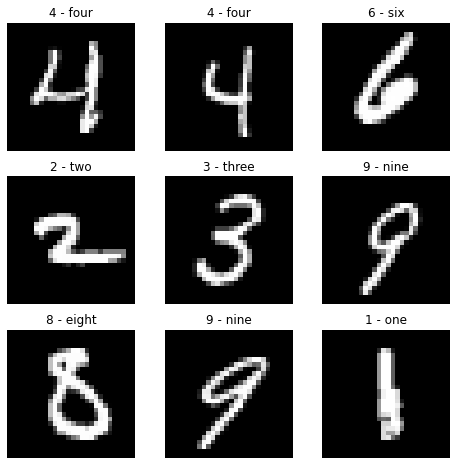

10000
torch.Size([1, 28, 28])


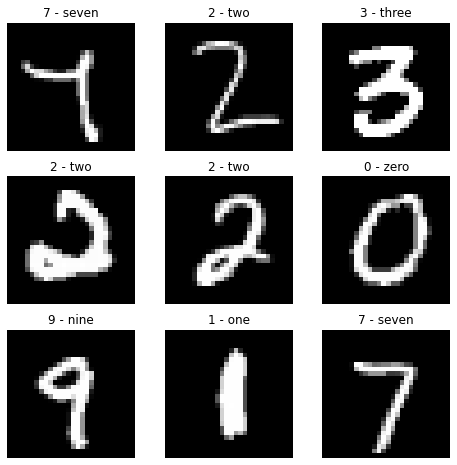

In [ ]:
def show_images_from_dataset(dataset, labels_dict, figure_size=(8, 8), cols=3, rows=3, save_image=False, save_address='dataset_samples.png'):
  '''
  This function plots (cols * rows) of random images from the dataset.
  dataset: name of a dataset object 
  labels_dict: a dictionary that gives the label's name
  figure_size: size of the plotted images - tuple of two scalars (s1, s2)
  cols: number of columns in the subplot - scalar
  rows: number of rows in the subplot - scalar
  save_image: if set to True, saves the the matplotlib plot to the given address
  save_address: address for saving the plot 
  '''
  figure = plt.figure(figsize=figure_size)
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      image, label = dataset[sample_idx]
      # image = (image + 1) / 2
      plt.subplot(rows, cols, i)
      plt.title(labels_dict[label])
      plt.axis("off")
      plt.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
  if save_image: plt.savefig(save_address, bbox_inches='tight')
  plt.show()

print(len(MNIST_training_data))
print(MNIST_training_data[0][0].shape)
show_images_from_dataset(MNIST_training_data, labels_dict, save_image=True, save_address='training_samples.png')

print(len(MNIST_test_data))
print(MNIST_test_data[0][0].shape)
show_images_from_dataset(MNIST_test_data, labels_dict, save_image=True, save_address='test_samples.png')

## model

In [ ]:
from math import floor 
def test_output_size_for_conv2d(input_size, kernel_size_test, stride_test):
  '''
  Calculates the output size (W or H) of the sequential conv2d layers
  input
  input_size: input size (W or H) of an image
  kernel_size_test:  a list of the kernel sizes of all the conv2d layers (their W or H)
  stride_test:  a list of the strides of the all the conv2d layers
  output
  Prints the output sizes for all the conv2d layers
  '''
  output_size_test = input_size
  print('Input size: ', output_size_test)
  for i in range(len(kernel_size_test)):
    output_size_test = floor(((output_size_test - kernel_size_test[i]) / stride_test[i]) + 1)
    print('Output size of the # {} convolutional layer is {}.'.format(i+1, output_size_test))
    
def test_output_size_for_convTranspose2d(input_size, kernel_size_test, stride_test):
  '''
  Calculates the output size (W or H) of the sequential convTranspose2d layers
  input
  input_size: input size (W or H) of an input (for decoder it is 1)
  kernel_size_test: a list of the kernel sizes of all convTranspose2d layers (their W or H)
  stride_test: a list of the strides of all convTranspose2d layers
  output
  Prints the output sizes for all the convTranspose2d layers
  '''
  output_size_test = input_size
  print('Input size: ', output_size_test)
  for i in range(len(kernel_size_test)):
    output_size_test = ((output_size_test - 1) * stride_test[i]) + kernel_size_test[i]
    print('Output size of the # {} transposed convolutional layer is {}.'.format(i+1, output_size_test))

In [ ]:
test_output_size_for_conv2d(28, [4, 4, 4, 3], [1, 2, 2, 2])

Input size:  28
Output size of the # 1 convolutional layer is 25.
Output size of the # 2 convolutional layer is 11.
Output size of the # 3 convolutional layer is 4.
Output size of the # 4 convolutional layer is 1.


In [ ]:
test_output_size_for_convTranspose2d(1, [5, 4, 4, 3], [1, 2, 2, 1])

Input size:  1
Output size of the # 1 transposed convolutional layer is 5.
Output size of the # 2 transposed convolutional layer is 12.
Output size of the # 3 transposed convolutional layer is 26.
Output size of the # 4 transposed convolutional layer is 28.


In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
  '''
  Encoder Class
  Values
  image_channels: number of the channels in the input image (3 for RGB images)
  latent_channels: number of the dimensions in the ouput point
  hidden_channels: multiple of the number of the channels for hidden layers
  '''
  def __init__(self, image_channels=1, latent_channels=32, hidden_channels=32):
    super(Encoder, self).__init__()
    self.latent_channels = latent_channels
    self.encod = nn.Sequential(
        self.conv_block(image_channels, hidden_channels, kernel_size=4, stride=1),
        self.conv_block(hidden_channels, 2 * hidden_channels, kernel_size=4, stride=2),
        self.conv_block(2 * hidden_channels, 4 * hidden_channels, kernel_size=4, stride=2),
        self.conv_block(4 * hidden_channels, 2 * latent_channels, kernel_size=3, stride=2, final_layer=True),
    )

  def conv_block(self, input_channels, output_channels, kernel_size=4, stride=1, final_layer=False):
    '''
    Constructs a block of operations that are repeated in the network.
    This block consists of a convolutional layer, a batchnorm layer, and an activation layer.
    Except for the last layer which only consists of a convolutional layer.
    input
    input_channels: number of the channels of the input of the conv2d layer
    output_channels: number of the channels of the output of the conv2d layer
    kernel_size: size of the kernel for the conv2d layer
    stride: stride for the conv2d layer
    final_layer: If the block is the last conv2d layer of the network, then It should be set to True.
    ouput
    Returns a sequence of operations as a convolutional block
    '''
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2),         
      )
    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      )

  def forward(self, image):
    '''
    Completes a forward pass of the network.
    Takes an image as input and encodes it as a point in the latent space 
    (their multivariate normal distribution parameters where all of the dimensions are independent)
    input
    image: takes an image as input
    output
    encoding: outputs a point in the latent space
    '''
    encoding = self.encod(image)
    encoding = encoding.reshape(len(encoding), -1)
    # The standard deviation outputs are treated as the log of the standard deviations of the normal 
    # distribution by convention and for numerical stability
    mu = encoding[:, :self.latent_channels] 
    std = encoding[:, self.latent_channels:].exp()
    return mu, std

class Decoder(nn.Module):
  ''' 
  Decoder Class
  Values
  noise_channels: number of the channels in the input noise (dimensions of the latent space)
  image_channels: number of the channels in the ouput image
  hidden_channels: multiple of the number of the channels for hidden layers
  '''
  def __init__(self, noise_channels=32, image_channels=1, hidden_channels=64):
    super(Decoder, self).__init__()
    self.noise_channels = noise_channels
    self.decod = nn.Sequential(
        self.convTranspose_block(noise_channels, 4 * hidden_channels, kernel_size=5, stride=1),
        self.convTranspose_block(4 * hidden_channels, 2 * hidden_channels, kernel_size=4, stride=2),
        self.convTranspose_block(2 * hidden_channels, hidden_channels, kernel_size=4, stride=2),
        self.convTranspose_block(hidden_channels, image_channels, kernel_size=3, stride=1, final_layer=True),
    )

  def convTranspose_block(self, input_channels, output_channels, kernel_size=4, stride=3, final_layer=False):
    '''
    Constructs a block of operations that are repeated in the network.
    This block consists of a transposed convolutional layer, a batchnorm layer, and an activation layer.
    Except for the last layer which only consists of a convolutional layer and an activation layer.
    input
    input_channels: number of the channels of the input of the convTranspose2d layer
    output_channels: number of the channels of the output of the convTranspose2d layer
    kernel_size: size of the kernel for the convTranspose2d layer
    stride: stride for the convTranspose2d layer
    final_layer: If the block is the last convTranspose2d layer of the network, then It should be set to True.
    ouput
    Returns a sequence of operations as a transposed convolutional block
    '''
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(),         
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.Sigmoid(),
      )

  def forward(self, noise):
    '''
    Completes a forward pass of the network
    Takes a point in the latent space as input and decodes it to an image
    input
    noise: a point in the latent space
    output
    decoding: outputs a generated image
    '''
    noise = noise.reshape(len(noise), self.noise_channels, 1, 1)
    decoding = self.decod(noise)
    return decoding

from torch.distributions.normal import Normal

class VAE(nn.Module):
  '''
  VAE Class
  input
  latent_channels: the dimensionality of the latent space (number of the channels in the noise)
  encoder_hidden_channels: multiple for the number of the channels in the layers of encoder
  decoder_hidden_channels: multiple for the number of the channels in the layers of decoder
  '''
  def __init__(self, latent_channels=32, encoder_hidden_channels=32, decoder_hidden_channels=64):
    super(VAE, self).__init__()
    self.encode = Encoder(latent_channels=latent_channels, hidden_channels=encoder_hidden_channels)
    self.decode = Decoder(noise_channels=latent_channels, hidden_channels=decoder_hidden_channels)

  def forward(self, images):
    '''
    Takes a batch of images and reconstructs them in output
    input
    images: color images with size 28 x 28
    output
    decoding: reconstructed color images with size 28 x 28
    '''
    mu, std= self.encode(images)
    dist = Normal(mu, std)
    samples = dist.rsample()
    decoding = self.decode(samples)
    return decoding, dist

## loss

In [ ]:
from torch.distributions.kl import kl_divergence

# The reconstruction loss of the reconstructed and original images
reconstruction_loss = nn.BCELoss(reduction='sum')

# Kl divergence of the distributions of the reconstructed images and the prior distribution of the latent space
# the prior distribution of the latent space was assumed to be a spherical normal distribution N(0,I)
def kl_divergence_loss(dist):
    return kl_divergence(
        dist, Normal(torch.zeros_like(dist.mean), torch.ones_like(dist.stddev))
    ).sum(-1)

## training

In [ ]:
from torchvision.utils import make_grid

def show_images_batch(images, number_images=15, nrow=3):
  '''
  Shows a number of images in a grid
  input
  images: a tensor of images (B, C, W, H)
  number_images: a number of images from the batch
  nrow: number of rows in the grid
  output
  A grid of images
  '''
  # images = (images + 1) / 2
  images = images.detach().cpu()
  image_grid = make_grid(images[:number_images], nrow=nrow)
  plt.axis('off')
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())

import glob
import os

def find_last_checkpoint(checkpoints_path, name_format):
  '''
  input
  checkpoints_path: the path to the folder containing all the relevant checkpoints
  name_format: the format for the full filename of checkpoints (a three part string similar to part1_part2.part3, 
  for example "dcnet_num.tar", where the second part is a number and should be left as "num"), a string
  output
  checkpoint_path: the path of the last checkpoint file 
  '''
  largest_epoch = 0
  part_1_part_2, _, part_3 = name_format.rpartition('.')
  part_1, _, part_2 = part_1_part_2.rpartition('_')
  if part_2 == 'best':
    checkpoint_path = checkpoints_path + name_format
  else:
    candidate_checkpoints = glob.glob(checkpoints_path + '*', recursive=False) 
    for candidate_checkpoint in candidate_checkpoints:
      parts_path = candidate_checkpoint.rpartition('.')
      if parts_path[2] == part_3:
        parts_rest = parts_path[0].rpartition('_')
        name_only = os.path.basename(parts_rest[0])
        if name_only == part_1:
          try: candidate_epoch = int(parts_rest[2])
          except: candidate_epoch = -1
          if candidate_epoch > largest_epoch:
            largest_epoch = candidate_epoch
            checkpoint_path = candidate_checkpoint
  return checkpoint_path

from tqdm import tqdm
import seaborn as sns
from math import ceil

def weights_init(m):
  '''
  This function initializes the weights of the given model.
  '''
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
      nn.init.normal_(m.weight, 0.0, 0.02)
      nn.init.constant_(m.bias, 0)

def train_vae(vae_dataset, n_epochs=10, batch_size=512, 
             lr=0.01, beta_1=0.9, beta_2=0.999,
             latent_channels=32, encoder_hidden_channels=32, decoder_hidden_channels=64, 
             device='cuda', show_loss=True, step_bins=20, 
             grid_images=True, output_losses=False,
             save_checkpoint=True, load_checkpoint=False,
             save_path='./', save_name_format='vae_num.tar',
             load_path='./', load_name_format='vae_num.tar',
             save_best_model=False):
  '''
  This function trains a vae for the given number of epochs and displys its results.
  input
  vae_dataset: a dataset object (dataset of 28 x 28 color images)
  n_epochs: number of epochs for training
  batch_size: the size of each batch in training
  lr: learning rate of Adam optimizer
  beta_1, beta_2: Adam optimizer parameters
  device: the type of device that is used for training ('cpu' or 'cuda')
  show_loss: If set to True, The average and last total loss of each epoch, and 
  the plot of the total loss for batches will be displayed.
  step_bins: the size of the each unit of x-axis in the loss plot
  grid_images: If grid_images is set to True, then Grids of original, average, and reconstructed images are displayed.
  output_losses: If set to True, Two lists of losses (vae_losses and vae_loss_means) will be returned.
  save_checkpoint: If set to True, The parameters of the model (ae and ae_opt) and important data (epoch, vae_losses, and vae_loss_means)
  are saved to .\vae_{epoch}.tar path.
  load_checkpoint: If set to True, The last checkpoint in the .\vae_{epoch}.tar path is loaded.
  (epoch is used to determine the last checkpoint)
  save_path: the path to the folder that checkpoints will be saved in
  load_path: the path to the folder containing all the relevant checkpoints
  save_name_format, load_name_format: the format for the full filename of checkpoints in the save_path and load_path folders repectively 
  (a three part string similar to part1_num.part3, for example "dcnet_num.tar", 
  where the second part is a number and should be left as "num"), a string
  save_best_model: If set to True, The model with best performance (minimum loss) is saved (with format vae_best.tar)
  output
  The average and last loss of each epoch, and the plot of loss against batches is displayed. (If show_loss is set to True)
  Grids of original, average, and reconstructed images are displayed. (If grid_images is set to True)
  vae_losses: a list of batch losses (If output_losses is True) 
  vae_loss_means: a list of average loss of each epoch (If output_losses is True) 
  '''

  # Creating an instance of the vae model
  vae = VAE(latent_channels=latent_channels, encoder_hidden_channels=encoder_hidden_channels, 
                  decoder_hidden_channels=decoder_hidden_channels).to(device)
  # Initiating the Adam optimizer for the vae weights
  vae_opt = torch.optim.Adam(vae.parameters(), lr=lr, betas=(beta_1, beta_2))
  # Initialize the weights of the vae and the parameters of the traning
  if load_checkpoint:
    try:
      # searches for the checkpoint files with vae_{epoch}.tar format (or any similar specified format) in the specified folder
      # and returns the checkpoint with the largest epoch number
      checkpoint_path = find_last_checkpoint(checkpoints_path=load_path, name_format=load_name_format)
      checkpoint = torch.load(checkpoint_path)
      vae.load_state_dict(checkpoint['vae'])
      vae_opt.load_state_dict(checkpoint['vae_opt'])
      init_epoch = checkpoint['epoch'] + 1
      vae_losses = checkpoint['vae_losses']
      vae_loss_means = checkpoint['vae_loss_means']
      try: loss_min = checkpoint['loss_min']
      except: loss_min = vae_loss_means[-1]
    except:
      print('load_checkpoint is set to True, but No checkpoints with {} format are found in "{}".'.format(load_name_format, load_path))
      print('Starting the training from the begining.')
      vae = vae.apply(weights_init)
      init_epoch = 0
      vae_losses = []
      vae_loss_means = []
      loss_min = 1e9
  else:
    vae = vae.apply(weights_init)
    init_epoch = 0
    vae_losses = []
    vae_loss_means = []
    loss_min = 1e9

  # Preparing the dataloader for training
  train_dataloader = DataLoader(vae_dataset, batch_size=batch_size, shuffle=True)

  # Putting the network in training mode
  vae.train()
  for epoch in range(init_epoch, n_epochs):
    print('Epoch {}:'.format(epoch))
    # Dataloader returns the batches
    for images, _ in tqdm(train_dataloader):

      # batch of input images
      images = images.to(device)

      # Clear out gradients
      vae_opt.zero_grad()
      # The network resconstructs the original images
      recon_images, dist= vae(images)
      # Calculate the loss
      recon_loss = reconstruction_loss(recon_images, images)
      kl_loss = kl_divergence_loss(dist).sum()
      # The total loss is the sum of reconstruction losses of the reconstructed and original images and 
      # kl divergence of the distributions of reconstructed images and prior distribution of the latent space
      loss = recon_loss + kl_loss
      # Calculate the gradients
      loss.backward()
      # Update the weights
      vae_opt.step()

      # Keeping track of the batch loss
      vae_losses.append(loss.item())
    # The number of samples are small, therefore I will evaluate the network per epoch
    # The average and last total losses are presented
    n_batches = ceil(len(vae_dataset) / batch_size)
    loss_mean = sum(vae_losses[-n_batches:]) / n_batches
    vae_loss_means.append(loss_mean)
    print('The average and last losses in this epoch are {:.4f} and {:.4f} respectively.'.format(loss_mean, loss.item())) 
    # Visualization of total loss
    if show_loss & ((epoch % 5 == 0) | (epoch == (n_epochs - 1))):
      step_bins = step_bins
      if len(vae_losses) < step_bins: step_bins = len(vae_losses)
      figure = plt.figure(figsize=(9,3))
      plt.subplot(1,2,1)
      x_axis = sorted([i * step_bins for i in range(len(vae_losses) // step_bins)] * step_bins)
      sns.lineplot(x=x_axis, y=vae_losses[:len(x_axis)], label='Loss')
      plt.title('Loss from the begining')
      plt.legend()
      plt.subplot(1,2,2)
      if epoch < 6: n_samples = len(vae_losses)
      else: n_samples = 5 * n_batches
      x_s_axis = sorted([i * step_bins for i in range(len(vae_losses[-n_samples:]) // step_bins)] * step_bins)
      sns.lineplot(x=x_s_axis, y=vae_losses[-len(x_s_axis):], label='Loss')
      plt.title('Loss for the last five epochs')
      plt.legend()
      plt.show()
    # Visualization of original and reconstructed images in grids
    if grid_images & ((epoch % 5 == 0) | (epoch == (n_epochs - 1))):
      figure = plt.figure(figsize=(15,25))
      plt.subplot(1,2,1)
      show_images_batch(images)
      plt.title('Original')
      plt.subplot(1,2,2)
      show_images_batch(recon_images)
      plt.title('Reconstructed')
      plt.show()
    # saves a checkpoint
    if save_checkpoint & ((epoch % 100 == 0) | (epoch == (n_epochs - 1))) & (epoch != 0):
      part_1_num, sep_1, part_3 = save_name_format.rpartition('.')
      part_1, sep_2, _ = part_1_num.rpartition('_')
      torch.save({'vae': vae.state_dict(),
                  'vae_opt': vae_opt.state_dict(),
                  'epoch': epoch,
                  'vae_losses': vae_losses,
                  'vae_loss_means': vae_loss_means,
              },  save_path + part_1 +sep_2+ str(epoch) +sep_1+ part_3)
    if save_best_model & (loss_mean < loss_min):
      loss_min = loss_mean
      part_1_num, sep_1, part_3 = save_name_format.rpartition('.')
      part_1, sep_2, _ = part_1_num.rpartition('_')
      torch.save({'vae': vae.state_dict(),
                  'vae_opt': vae_opt.state_dict(),
                  'epoch': epoch,
                  'vae_losses': vae_losses,
                  'vae_loss_means': vae_loss_means,
                  'loss_min': loss_min,
              },  save_path + part_1 +sep_2+ 'best' +sep_1+ part_3)
  if output_losses: return vae_losses, vae_loss_means

!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:1024'

## main training

load_checkpoint is set to True, but No checkpoints with vaep_best.tar format are found in "./".
Starting the training from the begining.
Epoch 0:


100%|██████████| 59/59 [00:14<00:00,  4.19it/s]


The average and last losses in this epoch are 329659.8602 and 104666.6250 respectively.


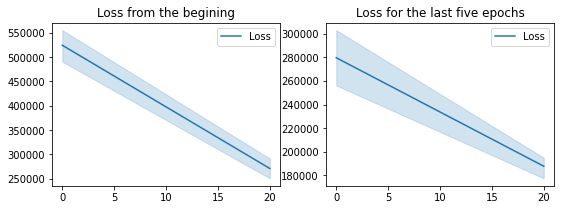

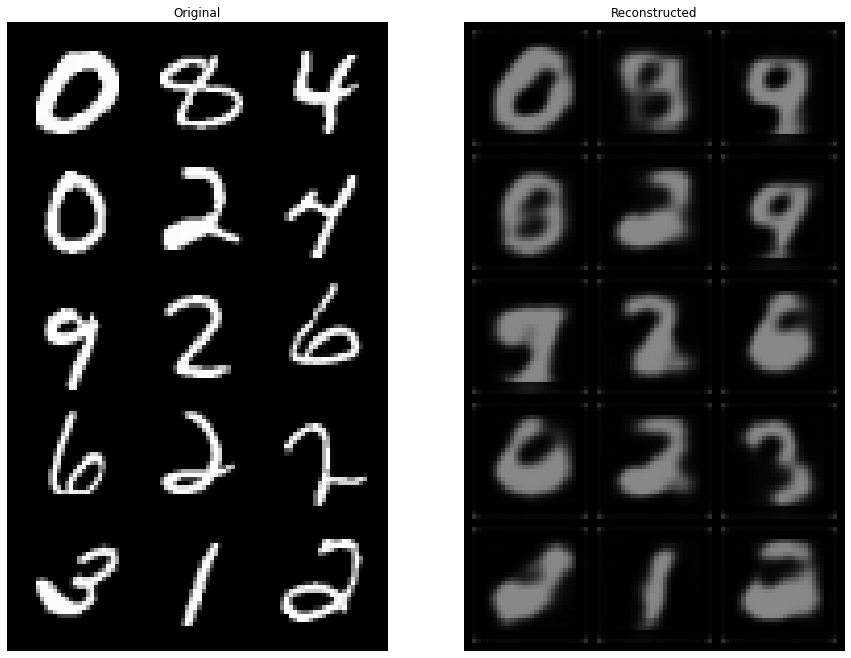

Epoch 1:


100%|██████████| 59/59 [00:12<00:00,  4.56it/s]


The average and last losses in this epoch are 159968.1123 and 88633.5781 respectively.
Epoch 2:


100%|██████████| 59/59 [00:12<00:00,  4.57it/s]


The average and last losses in this epoch are 129006.6333 and 70749.0703 respectively.
Epoch 3:


100%|██████████| 59/59 [00:12<00:00,  4.63it/s]


The average and last losses in this epoch are 115035.5403 and 67553.8750 respectively.
Epoch 4:


100%|██████████| 59/59 [00:12<00:00,  4.63it/s]


The average and last losses in this epoch are 111318.9029 and 66737.2500 respectively.
Epoch 5:


100%|██████████| 59/59 [00:12<00:00,  4.60it/s]


The average and last losses in this epoch are 109128.5945 and 64007.9414 respectively.


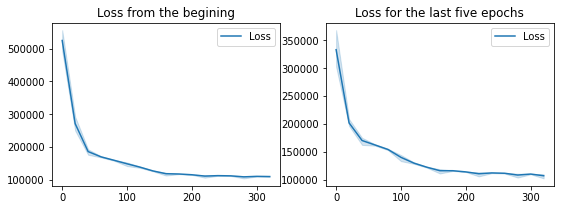

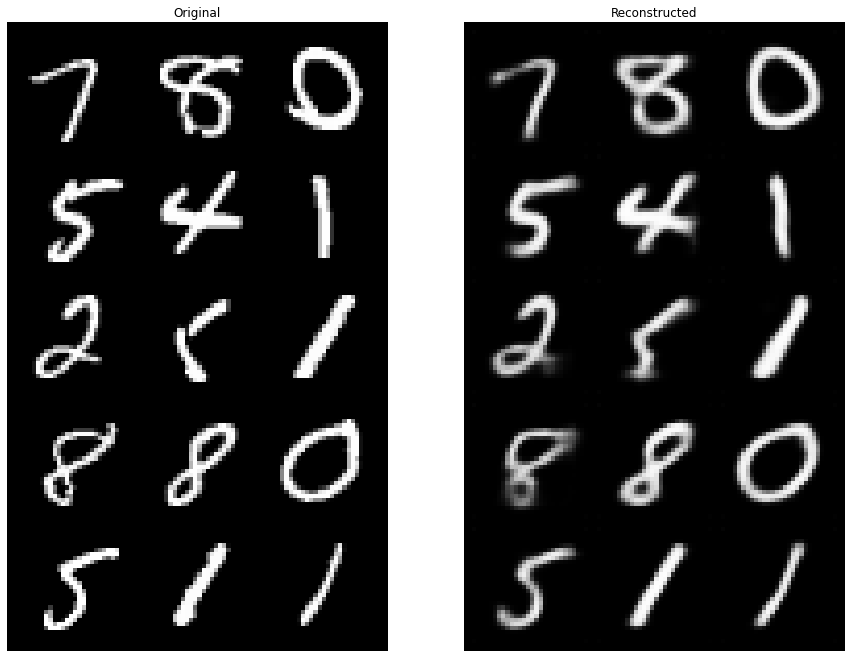

Epoch 6:


100%|██████████| 59/59 [00:12<00:00,  4.60it/s]


The average and last losses in this epoch are 107945.3735 and 65839.3516 respectively.
Epoch 7:


100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


The average and last losses in this epoch are 106956.6893 and 64072.9492 respectively.
Epoch 8:


100%|██████████| 59/59 [00:12<00:00,  4.55it/s]


The average and last losses in this epoch are 106297.1656 and 62698.1602 respectively.
Epoch 9:


100%|██████████| 59/59 [00:12<00:00,  4.60it/s]


The average and last losses in this epoch are 105594.5538 and 61769.3398 respectively.


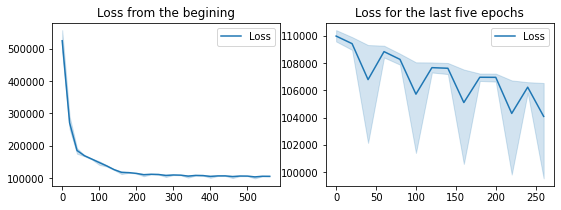

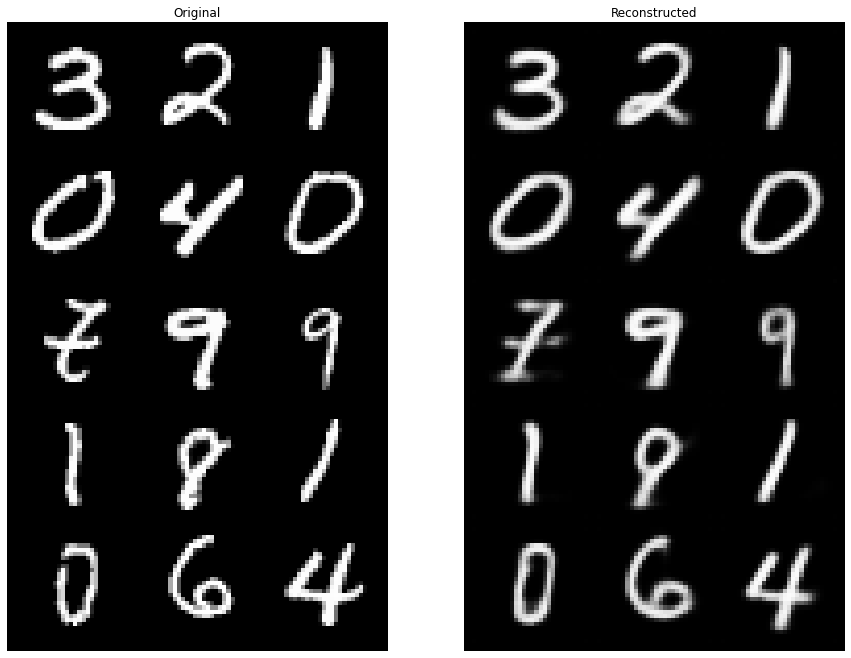

In [ ]:
hyperparameters_default = {
    'vae_dataset': MNIST_training_data,
    'n_epochs': 10, 'batch_size': 1024,
    'lr': 0.002, 'beta_1': 0.9, 'beta_2': 0.999,
    'latent_channels': 32, 'encoder_hidden_channels': 32, 'decoder_hidden_channels': 64,
    'device': 'cuda', 
    'show_loss': True, 'step_bins': 20, 'grid_images': True,
    'output_losses': False,
    'save_checkpoint': True, 'load_checkpoint': True,
    'save_path': './', 'save_name_format': 'vaep_num.tar',
    # 'load_path': './', 'load_name_format': 'vaep_num.tar',
    'load_path': './', 'load_name_format': 'vaep_best.tar',
    'save_best_model': True,
}

train_vae(vae_dataset=hyperparameters_default['vae_dataset'], 
          n_epochs=hyperparameters_default['n_epochs'], batch_size=hyperparameters_default['batch_size'], 
          lr=hyperparameters_default['lr'], 
          beta_1=hyperparameters_default['beta_1'], beta_2=hyperparameters_default['beta_2'], 
          latent_channels=hyperparameters_default['latent_channels'], 
          encoder_hidden_channels=hyperparameters_default['encoder_hidden_channels'], 
          decoder_hidden_channels=hyperparameters_default['decoder_hidden_channels'], 
          device=hyperparameters_default['device'], 
          show_loss=hyperparameters_default['show_loss'], 
          step_bins=hyperparameters_default['step_bins'], 
          grid_images=hyperparameters_default['grid_images'], output_losses=hyperparameters_default['output_losses'],
          save_checkpoint=hyperparameters_default['save_checkpoint'], 
          load_checkpoint=hyperparameters_default['load_checkpoint'],
          save_path=hyperparameters_default['save_path'], save_name_format=hyperparameters_default['save_name_format'],
          load_path=hyperparameters_default['load_path'], load_name_format=hyperparameters_default['load_name_format'],
          save_best_model=hyperparameters_default['save_best_model'])

## Evaluation

In [ ]:
def evaluate_vae(hyperparameters_default, test_dataset, load_path, load_name_format, grid_images=True, 
                 save_image=False, save_address='eval_samples.png'):
  '''
  This function displays a number of random original and reconstructed images from training and test datasets in grids.
  Also, this function presents the average total loss for all the images in these two datasets in a table.
  input
  hyperparameters_default: a python dictionary consisting of the default (current) values of all hyperparameters
  test_dataset: a dataset object (dataset of 28 x 28 color images) that the network wasn't trained on
  load_path: the path to the folder containing all the relevant checkpoints
  load_name_format: the format for the full filename of checkpoints in the load_path folder (a three part string similar to 
  part1_part2.part3, for example "dcnet_num.tar", where the second part is a number and should be left as "num"), a string
  grid_images: If grid_images is set to True, then Grids of original, average, and reconstructed images are displayed.
  save_image: if set to True, saves the the matplotlib plot to the given address
  save_address: address for saving the plot
  '''
  device = hyperparameters_default['device']
  # Creating an instance of the autoencoder model
  vae = VAE(latent_channels=hyperparameters_default['latent_channels'], 
          encoder_hidden_channels=hyperparameters_default['encoder_hidden_channels'], 
          decoder_hidden_channels=hyperparameters_default['decoder_hidden_channels']).to(device)
  # Loading the network weights
  try:
    checkpoint_path = find_last_checkpoint(checkpoints_path=load_path, name_format=load_name_format)
  except:
    checkpoint_path = load_path + load_name_format
  checkpoint = torch.load(checkpoint_path)
  vae.load_state_dict(checkpoint['vae'])
  # Putting the network on evaluation mode 
  vae.eval()

  # Preparing the dataloaders
  batch_size = hyperparameters_default['batch_size']
  datasets = [hyperparameters_default['vae_dataset'], test_dataset]
  train_dataloader = DataLoader(datasets[0], batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(datasets[1], batch_size=batch_size, shuffle=True)

  datasets_str = ['Training dataset', 'Test dataset']
  image_name_str = ['training', 'test']
  vae_losses = []
  vae_loss_means = []
  for indx, dataloader in enumerate([train_dataloader, test_dataloader]):
    # Dataloader returns the batches
    for batch_indx, (images, _) in enumerate(dataloader):

      # a batch of images as the input
      images = images.to(device)

      # The network resconstructs the original images
      recon_images, dist = vae(images)
      # Calculate the loss
      recon_loss = reconstruction_loss(recon_images, images)
      kl_loss = kl_divergence_loss(dist).sum()
      # The total loss is the sum of reconstruction losses of the reconstructed and original images and 
      # kl divergence of the distributions of reconstructed images and prior distribution of the latent space
      loss = recon_loss + kl_loss

      # Keeping track of the batch loss
      vae_losses.append(loss.item())

      # Visualization of original and reconstructed images in grids
      if grid_images & (batch_indx==0):
        figure = plt.figure(figsize=(15,25))
        plt.subplot(1,2,1)
        show_images_batch(images)
        plt.title('Original', fontsize=15)
        plt.subplot(1,2,2)
        show_images_batch(recon_images)
        plt.title('Reconstructed', fontsize=15)
        plt.suptitle(datasets_str[indx], y=0.7, fontsize=20)
        if save_image: 
          part_1, _, part_2 = save_address.rpartition('.')
          save_address_temp = part_1 + '_' + image_name_str[indx] + '.' + part_2
          plt.savefig(save_address_temp, bbox_inches='tight')
        plt.show()

    n_batches = ceil(len(datasets[indx]) / batch_size)
    loss_mean = sum(vae_losses[-n_batches:]) / n_batches
    vae_loss_means.append(loss_mean)

  # The average loss is presented
  print('{:20}{:<32}'.format('', 'The average loss'))
  for i in range(len(vae_loss_means)):
    print('{:20}{:<32.4f}'.format(datasets_str[i], vae_loss_means[i]))

## Final evaluation

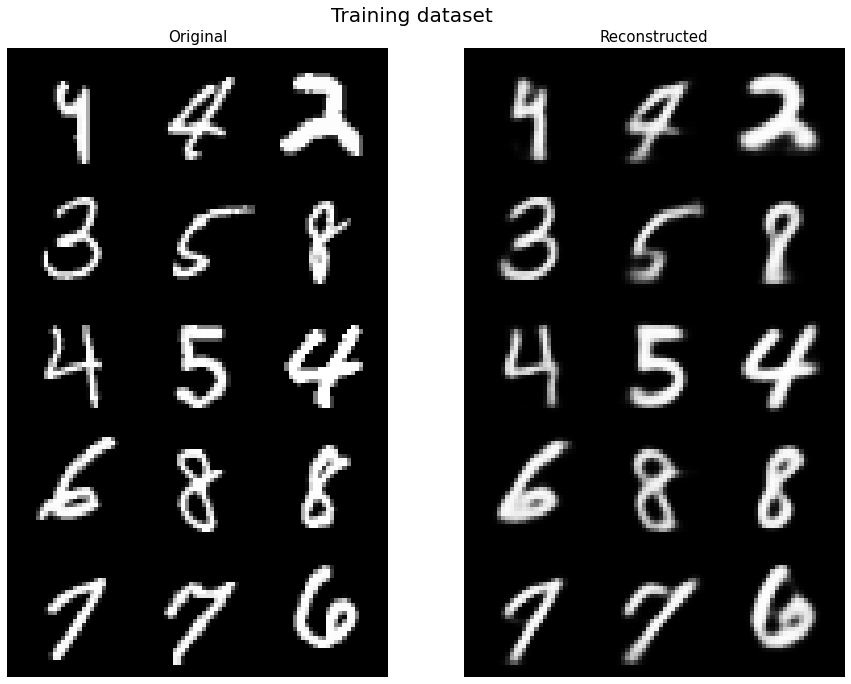

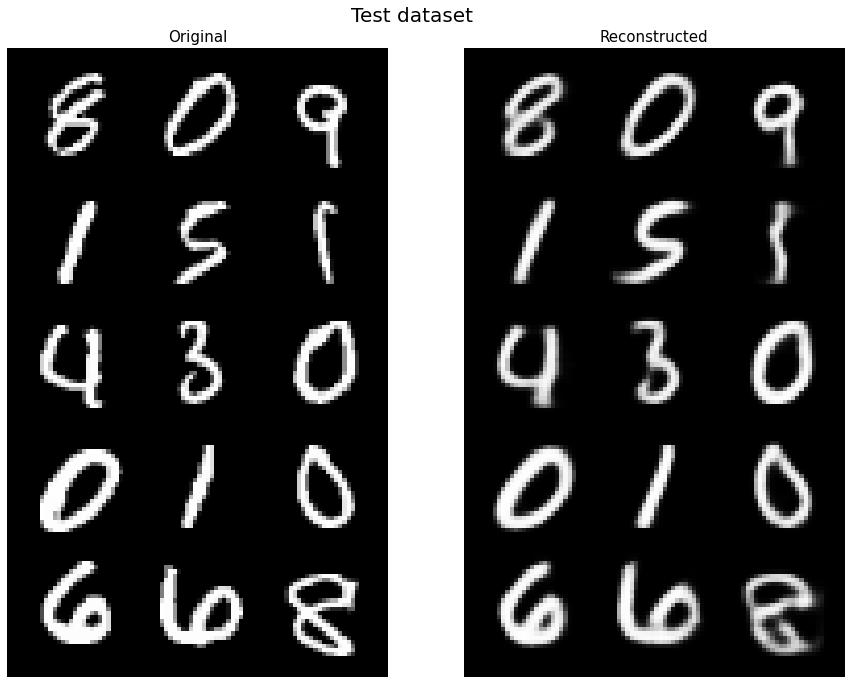

                    The average loss                
Training dataset    106221.8272                     
Test dataset        104538.3461                     


In [ ]:
hyperparameters_default_eval = {
    'vae_dataset': MNIST_training_data, 'batch_size': 1024,
    'latent_channels': 32, 'encoder_hidden_channels': 32, 'decoder_hidden_channels': 64,
    'device': 'cuda',
}

load_path='./' 
load_name_format='vaep_best.tar'
test_dataset = MNIST_test_data

evaluate_vae(hyperparameters_default_eval, test_dataset, load_path, load_name_format, grid_images=True,
             save_image=True, save_address='eval_samples.png')

# google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


copy the last checkpoint from the current directory to the google drive 

In [ ]:
checkpoints_path='./'
# name_format='vaep_num.tar'
name_format='vaep_best.tar'
checkpoint_path = find_last_checkpoint(checkpoints_path, name_format)
print(checkpoint_path)
!cp -r $checkpoint_path /content/gdrive/MyDrive/

./vaep_best.tar


copy the last checkpoint from the google drive to the current directory

In [ ]:
checkpoints_path = '/content/gdrive/MyDrive/'
# name_format='vaep_num.tar'
name_format='vaep_best.tar'
checkpoint_path = find_last_checkpoint(checkpoints_path, name_format)
print(checkpoint_path)
!cp -r $checkpoint_path /content/

/content/gdrive/MyDrive/vaep_best.tar


# Clearing GPU memory

In [ ]:
# # !nvidia-smi
# torch.cuda.empty_cache()

# html file
Converting the jupyter notebook to an html file

In [1]:
!jupyter nbconvert --to html /content/VAE_MNIST.ipynb

[NbConvertApp] Converting notebook /content/VAE_MNIST.ipynb to html
[NbConvertApp] Writing 739641 bytes to /content/VAE_MNIST.html
